**Malaria Detection Model**

Ins this model I'm going to train a malaria detection model using tensorflow

Import Required Packages

In [6]:
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, SeparableConv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19

# Display plots inline
%matplotlib inline

# Check TensorFlow version
print("Tensorflow version " + tf.__version__)


Tensorflow version 2.15.0


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unzip the data
local_zip = '/content/drive/MyDrive/cell_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/')
zip_ref.close()

**Now We Load the dataset and split it into train set, test set and Validation set**

In [8]:
base_path = '/content/drive/MyDrive/cell_images'
print(os.listdir(base_path))
print(f'Total Parasitized images {len(os.listdir(os.path.join(base_path, "Parasitized")))}')
print(f'Total Uninfected images {len(os.listdir(os.path.join(base_path, "Uninfected")))}')


['Parasitized', 'Uninfected']
Total Parasitized images 14283
Total Uninfected images 13780


In [9]:
pip install split-folders

In [10]:
import os
import splitfolders

base_path = '/content/drive/MyDrive/cell_images'
input_folder = base_path  # The input folder is specified by base_path
output_folder = '/content/drive/MyDrive/images'

os.mkdir(output_folder)  # folder store the Training, Validation, and Testing datasets

splitfolders.ratio(input_folder, output=output_folder, seed=10, ratio=(.85, .10, .05), group_prefix=None) # default values


Copying files: 28063 files [19:56, 23.45 files/s]


In [11]:
# Verifying the newly created folder structure
import os
input_path = '/content/drive/MyDrive/images'
for folder in os.listdir(input_path):
    print(folder)
    print(os.listdir(os.path.join(input_path, folder)))

train
['Parasitized', 'Uninfected']
val
['Parasitized', 'Uninfected']
test
['Parasitized', 'Uninfected']


In [12]:
train_dir = os.path.join(input_path, 'train')
test_dir = os.path.join(input_path, 'test')
val_dir = os.path.join(input_path, 'val')

train_Parasitized_dir = os.path.join(train_dir, 'Parasitized')
train_Uninfected_dir = os.path.join(train_dir, 'Uninfected')

validation_Parasitized_dir = os.path.join(val_dir, 'Parasitized')
validation_Uninfected_dir = os.path.join(val_dir, 'Uninfected')

test_Parasitized_dir = os.path.join(test_dir, 'Parasitized')
test_Uninfected_dir = os.path.join(test_dir, 'Uninfected')

In [13]:
print('total training Parasitized images :', len(os.listdir(train_Parasitized_dir) ))
print('total training Uninfected images :', len(os.listdir(train_Uninfected_dir) ))

print('total validation Parasitized images :', len(os.listdir(validation_Parasitized_dir) ))
print('total validation Uninfected images :', len(os.listdir(validation_Uninfected_dir) ))

print('total test Parasitized images :', len(os.listdir(test_Parasitized_dir) ))
print('total test Uninfected images :', len(os.listdir(test_Uninfected_dir) ))

total training Parasitized images : 12140
total training Uninfected images : 11713
total validation Parasitized images : 1428
total validation Uninfected images : 1378
total test Parasitized images : 715
total test Uninfected images : 689


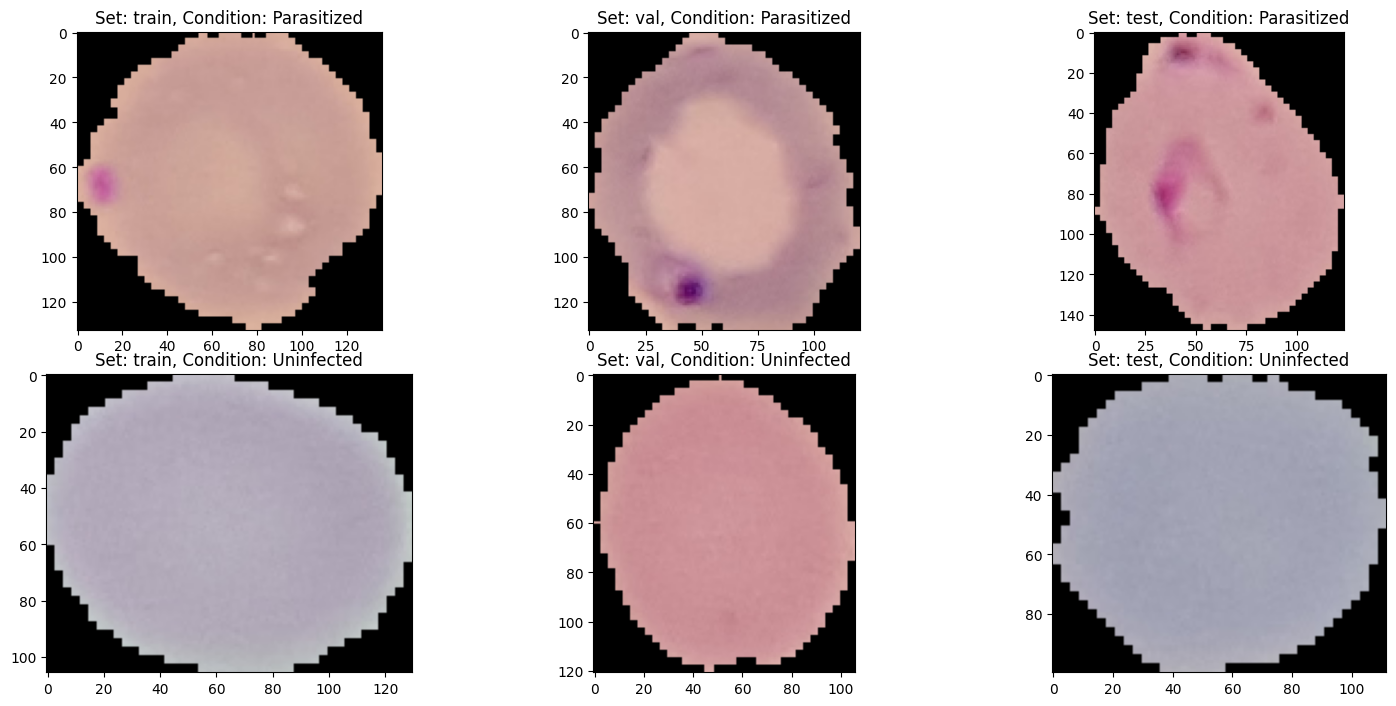

In [14]:
input_path = '/content/drive/MyDrive/images/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/Parasitized/'+os.listdir(set_path+'/Parasitized')[0]))
    ax[i].set_title('Set: {}, Condition: Parasitized'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/Uninfected/'+os.listdir(set_path+'/Uninfected')[0]))
    ax[i+3].set_title('Set: {}, Condition: Uninfected'.format(_set))

# Model Building
Here I will  be using the pretrained VGG19 model which is a convolutional neural network that is 19 layers deep. It consists of 16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer.

NB//we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [15]:
# defining some fixed parameters
image_shape = [224, 224]
batch_size = 64
epochs = 35

# total number of train and validation images
training_img_count = len(os.listdir(train_Parasitized_dir) ) + len(os.listdir(train_Uninfected_dir) )
validation_img_count = len(os.listdir(validation_Parasitized_dir) ) + len(os.listdir(validation_Uninfected_dir) )

print(f'total training images: {training_img_count}')
print(f'total validation images: {validation_img_count}')

total training images: 23853
total validation images: 2806


In [16]:
# instantiating the VGG19 model
vgg19 = VGG19(input_shape=(image_shape[0], image_shape[1], 3),
                  weights='imagenet', # include the pre-trained weights on ImageNet
                  include_top=False)  # to use our own input and get the desired output

# do not train the existing weights
for layer in vgg19.layers:
  layer.trainable = False

# defining input and output to the model
x = tf.keras.layers.Flatten()(vgg19.output)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs = vgg19.input, outputs = output)

80134624/80134624 [==============================] - 0s 0us/step


# Data Augmentation and Processing
Next I will  set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to the network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 224x224 and their labels (binary).

We will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

I will also augment the data to add new images to our dataset as this will prevent overfitting and the model will be able to generalize well to unseen data.


In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (image_shape[0], image_shape[1]),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    shuffle = True
                                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                  target_size = (image_shape[0], image_shape[1]),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  shuffle = True
                                                 )

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (image_shape[0], image_shape[1]),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  shuffle = True)

Found 23851 images belonging to 2 classes.
Found 2806 images belonging to 2 classes.
Found 1404 images belonging to 2 classes.


# Model Training
We will now configure the specifications for model training. We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid. We will use the adam optimizer. During training, we will want to monitor classification accuracy, recall, precision and loss.



In [18]:
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
          ]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = metrics)

# stop model training is the validation loss does not decrease for 5 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=10,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True
)

# reducing the learning rate every 5 epochs
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='malaria.keras',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode='min',
                                                save_freq='epoch'
)

In [19]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=training_img_count // batch_size,
                    epochs=epochs,
                    validation_steps=validation_img_count // batch_size,
                    callbacks=[early_stop, lr_scheduler, checkpoint],
                    verbose=2
                    )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/35

Epoch 1: val_loss improved from inf to 0.31543, saving model to malaria.keras
372/372 - 335s - loss: 0.3929 - accuracy: 0.8266 - precision: 0.8073 - recall: 0.8495 - val_loss: 0.3154 - val_accuracy: 0.8754 - val_precision: 0.9346 - val_recall: 0.8027 - lr: 0.0010 - 335s/epoch - 900ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/35

Epoch 2: val_loss improved from 0.31543 to 0.28453, saving model to malaria.keras
372/372 - 176s - loss: 0.2645 - accuracy: 0.8977 - precision: 0.8773 - recall: 0.9203 - val_loss: 0.2845 - val_accuracy: 0.8717 - val_precision: 0.8008 - val_recall: 0.9822 - lr: 0.0010 - 176s/epoch - 473ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/35

Epoch 3: val_loss improved from 0.28453 to 0.23580, saving model to malaria.keras
372/372 - 172s - loss: 0.2262 - accuracy: 0.9134 - precision: 0.8932 - recall: 0.9355 - val_loss: 0.2358 -

# Visualizing model performance

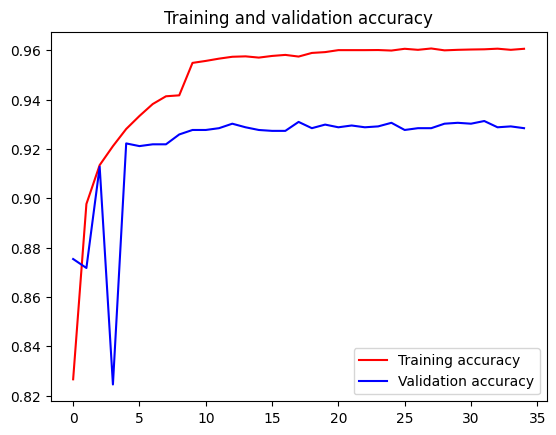

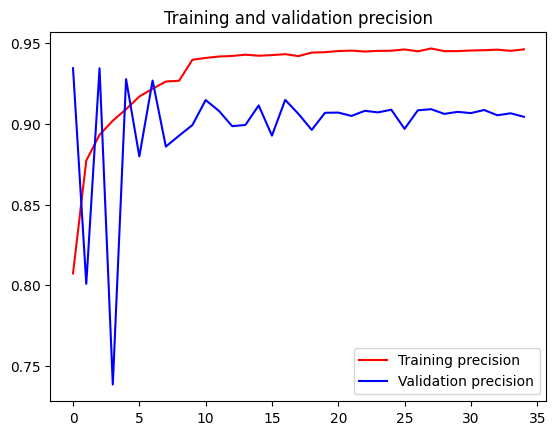

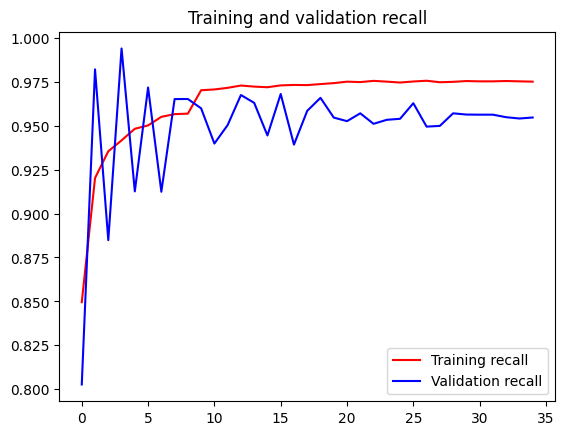

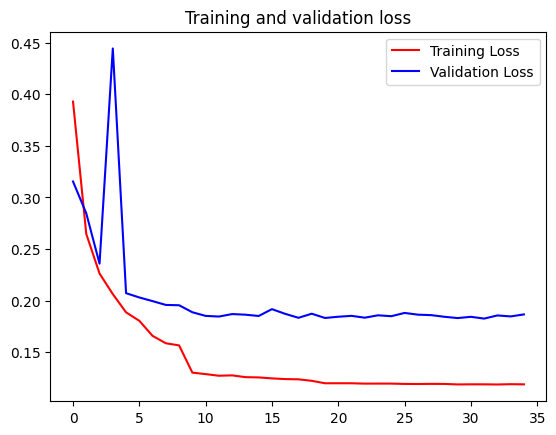

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']


epochs = range(len(acc))
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Model prediction and evaluation on unseen data

In [22]:
# load the saved model
saved_model = tf.keras.models.load_model('malaria.keras')
model_test_performace = saved_model.evaluate(test_generator)
test_accuracy = model_test_performace[1]
test_precision = model_test_performace[2]
test_recall = model_test_performace[3]

print(f'Test accuracy: {round(test_accuracy*100, 2)}%')
print(f'Test precision: {round(test_precision*100, 2)}%')
print(f'Test recall: {round(test_recall*100, 2)}%')

22/22 [==============================] - 21s 910ms/step - loss: 0.1785 - accuracy: 0.9359 - precision: 0.9177 - recall: 0.9550
Test accuracy: 93.59%
Test precision: 91.77%
Test recall: 95.5%
